In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import scipy.stats as sps
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.linalg import svdvals

from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from collections import Counter

from itertools import product
from tqdm import tqdm_notebook

import seaborn as sns
sns.set(font_scale=1.2)

N - количество клеток,  
a - ожидаемая доля искомых клеток,  
p - количество известных маркеров для искомой клетки,  
G - количество генов

In [3]:
# пересчет параметров для отрицаетльного биномиального распределения
def nbinom_params(m, s):
    p = m / (s*s)
    n = int(m*m / (s*s - m)) + 1
    return p, n

In [5]:
times = 20
k_max, k_num = 8, 8*10+1
t = 0

N_list = [100]
A_list = [0.1, 1e-2]
P_list = [5, 10]
G_list = [1e4, 1e5]

In [6]:
results = np.zeros((16, times, k_num))

for N, a, P, G in tqdm_notebook(list(product(N_list, A_list, P_list, G_list))):
    N, G = int(N), int(G)
    
    M = sps.uniform.rvs(loc=0, scale=1000, size=N)
    S = sps.uniform.rvs(loc=np.ceil(np.sqrt(M)), scale=M/2, size=len(M))
    
    for i in range(times):
        expressions = np.zeros((G, N))
        
        # все гены
        for gene, m, s in zip(range(G), M, S):
            p, n = nbinom_params(m, s)
            expressions[gene] = sps.nbinom.rvs(n=n, p=p, size=N)

        for j, k in enumerate(np.linspace(1, k_max, k_num)):
            N_spec = int(N*a)
            for gene, m, s in zip(range(P), M, S):
                m = m * k
                s = s * np.sqrt(k)
                p, n = nbinom_params(m, s)
                expressions[gene][:N_spec] = sps.nbinom.rvs(n=n, p=p, size=N_spec)
            X = expressions.T 
            y = np.zeros(N)
            y[:N_spec] = 1

            n_components = 2

            pca = PCA(n_components=n_components)
            sc = StandardScaler()
            X_pca = sc.fit_transform(pca.fit_transform(X))
            del pca
            
            db = DBSCAN(eps=0.5)
            y_pred = db.fit_predict(X_pca)
            del db

            if len(Counter(y_pred)) > 3:
                results[t][i][j] = np.nan
            else:
                results[t][i][j] = np.max([f1_score((y_pred != 0).astype(int), y.astype(int)), 
                                       f1_score((y_pred != 0).astype(int), 1-y.astype(int))])
    t += 1

In [7]:
params =  np.array(list(product(N_list, A_list, P_list, G_list)))
params

array([[1.e+02, 1.e-01, 5.e+00, 1.e+04],
       [1.e+02, 1.e-01, 5.e+00, 1.e+05],
       [1.e+02, 1.e-01, 1.e+01, 1.e+04],
       [1.e+02, 1.e-01, 1.e+01, 1.e+05],
       [1.e+02, 1.e-02, 5.e+00, 1.e+04],
       [1.e+02, 1.e-02, 5.e+00, 1.e+05],
       [1.e+02, 1.e-02, 1.e+01, 1.e+04],
       [1.e+02, 1.e-02, 1.e+01, 1.e+05]])

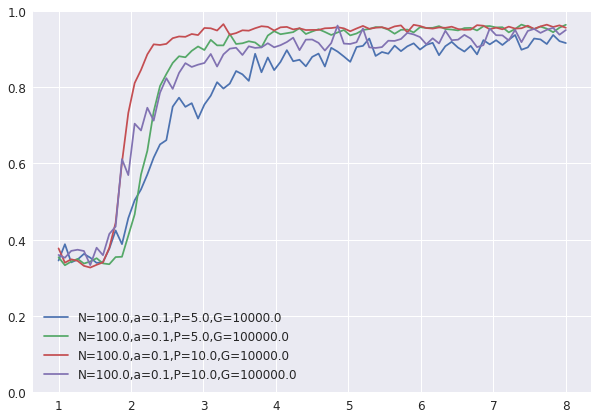

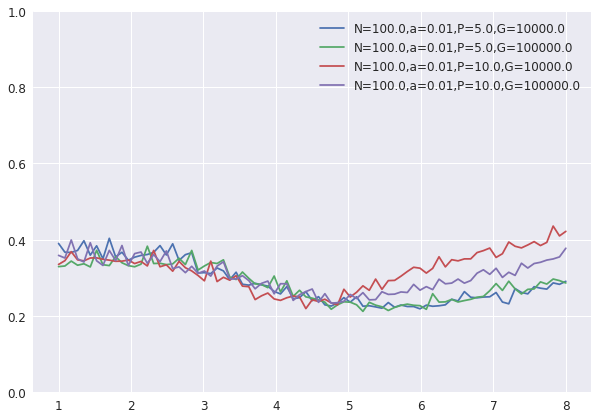

In [8]:
Ns = params.T[0]
mask = Ns==200
plt.figure(figsize=(10, 7))
for i, param in enumerate(params):
    if param[1] == 0.1:
        plt.plot(np.linspace(1, k_max, k_num), np.nanmean(results[i], axis=0), label='N={},a={},P={},G={}'.format(*param))
plt.legend()
plt.ylim((0, 1))

plt.figure(figsize=(10, 7))
for i, param in enumerate(params):
    if param[1] == 0.01:
        plt.plot(np.linspace(1, k_max, k_num), np.nanmean(results[i], axis=0), label='N={},a={},P={},G={}'.format(*param))
plt.legend()
plt.ylim((0, 1));

In [10]:
np.save('results_100.npy', results)

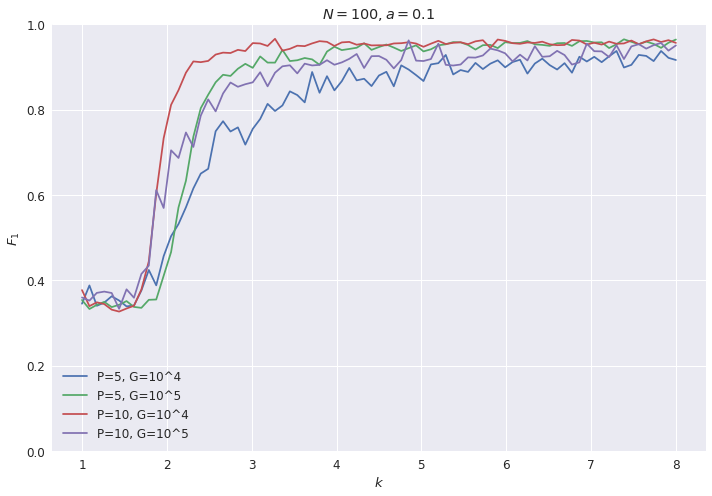

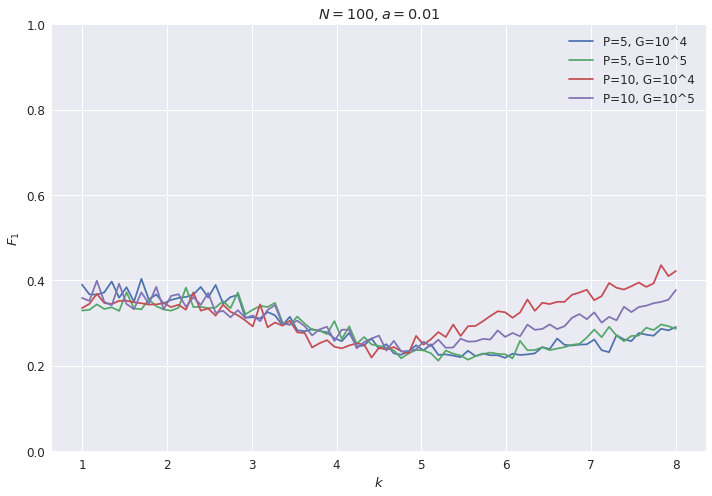

In [30]:
plt.figure(figsize=(10, 7))
for i, param in enumerate(params):
    if param[1] == 0.1:
        plt.plot(np.linspace(1, k_max, k_num), np.nanmean(results[i], axis=0), 
                 label='P={}, G=10^{}'.format(int(param[2]), int(np.log10(param[3]))))
plt.legend()
plt.xlabel('$k$'), plt.ylabel('$F_1$')
plt.title('$N={}, a=0.1$'.format(N))
plt.ylim((0, 1))
plt.tight_layout()
plt.savefig('pic/N={}, a=0.1.png'.format(N))

plt.figure(figsize=(10, 7))
for i, param in enumerate(params):
    if param[1] == 0.01:
        plt.plot(np.linspace(1, k_max, k_num), np.nanmean(results[i], axis=0), 
                 label='P={}, G=10^{}'.format(int(param[2]), int(np.log10(param[3]))))
plt.legend()
plt.xlabel('$k$'), plt.ylabel('$F_1$')
plt.title('$N={}, a=0.01$'.format(N, a))
plt.ylim((0, 1))
plt.tight_layout()
plt.savefig('pic/N={}, a=0.01.png'.format(N))